# OneMax Example

This tutorial explains how to implement custom representations, using `evokit.evolvables.binstring` as example.

In [1]:
import os
import sys
nb_dir = os.path.abspath(os.path.join('..', '..', '..'))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

To begin, implement a custom representation. All custom representations must derive `evokit.core.population.Individual`, store the genotype in `Individual.genome`, and override `Individual.copy`.

The implementation decides how to create new individuals. Here, this capability is implemented as `BinaryString.random`, which creates a random bit string of a certain length.

In [6]:
from __future__ import annotations
from typing import List, Self

from random import getrandbits
from evokit.core.population import Individual

class BinaryString(Individual[List[int]]):
    def __init__(self, value: List[int]) -> None:
        self.genome: List[int] = value

    @staticmethod
    def random(len: int) -> BinaryString:
        return BinaryString(
            (len * [0] +
                [int(digit) for digit in bin(getrandbits(len))[2:]])[-len:]
        )

    def copy(self: Self) -> Self:
        return type(self)(self.genome.copy())

    def __str__(self: Self) -> str:
        return str(self.genome)

Then, implement a custom evaluator. All custom evaluators must derive `evokit.core.evaluator.Evaluator` and override `Evaluator.evaluate`.

Here, `BitDistanceEvaluator` sums all bits in the genotype of a `BinaryString`.

In [9]:
from evokit.core.evaluator import Evaluator
from typing import override

class BitDistanceEvaluator(Evaluator[BinaryString]):
    @override
    def evaluate(self, s1: BinaryString) -> float:
        return sum(s1.genome)

Then, implement a custom variator. All variators must derive `evokit.core.variator.Variator` and override `Variator.vary`.

This variator has `arity=1`, means that it only takes one parent. Consequently, its `vary` method can expect a tuple of size 1. As a courtesy to users, the variator should also declares its `coarity` - the number of offspring produced from parents - but this is not enforced.

Note that the `coarity` of an operator may not always indicate its actual behaviour. Operators may be dynamically modified - such as with the `Elitist` interceptor - to produce a different number of offspring.

In [14]:
from random import random
from typing import Sequence, Tuple

from evokit.core.variator import Variator

class RandomBitMutator(Variator[BinaryString]):
    def __init__(self, mutation_rate: float):
        self.arity = 1
        self.coarity = 2
        if (mutation_rate < 0 or mutation_rate > 1):
            raise ValueError(f"Mutation rate must be within {0} and {1}."
                             f"Got: {mutation_rate}")
        self.mutation_rate = mutation_rate

    def vary(self, parents: Sequence[BinaryString]) -> Tuple[BinaryString, ...]:
        offspring = parents[0].copy()

        for i in range(0, len(offspring.genome)):
            if (random() < self.mutation_rate):
                offspring.genome[i] = 1 if offspring.genome[i] == 0 else 1

        return (offspring,)

Design the learning algorithm. Since selectors and the algorithm do not depend on representations, the framework comes with generic ones that should work with all representations. Import a selector and an algorithm from `evokit.core.selector` and `evokit.core.controller` respectively.

In [15]:
from evokit.core.selector import Elitist, SimpleSelector

from evokit.core.controller import SimpleLinearController

Initialise the population. Create a number of `BinaryString` instances, then store then in a `Population`.

In [16]:
from evokit.core.population import Population

BINSTRING_LENGTH: int = 1000
POPULATION_SIZE: int = 20
GENERATION_COUNT: int = 100
init_pop = Population[BinaryString]()

for i in range(0, POPULATION_SIZE):
    init_pop.append(BinaryString.random(BINSTRING_LENGTH))

Initialise operators, then run the algorithm with these operators.

In [18]:
ctrl: SimpleLinearController = SimpleLinearController(
    population=init_pop,
    variator=RandomBitMutator(0.1),
    selector=Elitist(SimpleSelector[BinaryString](POPULATION_SIZE)),
    evaluator = BitDistanceEvaluator()
)

Run the algorithm, then retain the best individual of each generation. Remember to call `copy`, so that subsequent modifications on the individual do not affect the retained copy.

In [19]:
bests = []

for _ in range(GENERATION_COUNT):
    ctrl.step()
    bests.append(ctrl.population[0])

Print best individuals of the first and last generations. Note the that the latter has significantly higher fitness.

In [24]:
print(f"Best individual of the first generation is {bests[0]}")
print(f"    with fitness {sum(bests[0].genome)}")
print(f"Best individual of the last generation is {bests[-1]}")
print(f"    with fitness {sum(bests[-1].genome)}")

Best individual of the first generation is [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,

Plot the training curve of best individuals:

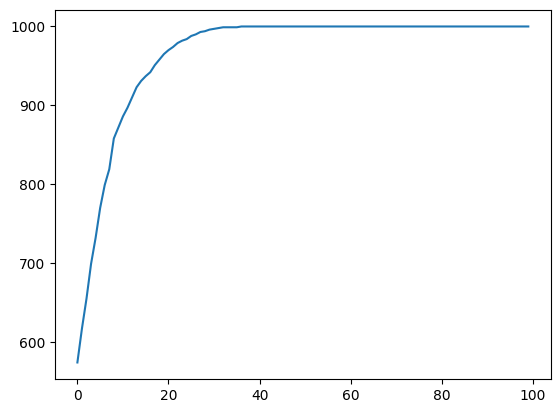

In [28]:
from matplotlib import pyplot as plt
plt.title('Training Curve of the Custom Algorithm')
plt.xlabel('categories')
plt.ylabel('values')
plt.plot([i for i in range(len(bests))], [sum(x.genome) for x in bests])
plt.show()